# Dynamic Pricing with Causal Machine Learning and Optimization on Amazon SageMaker

This notebook describes and implements a dynamic pricing experiment on Amazon SageMaker.

### Table of contents

1. Generate synthetic data
    1. Input parameters
    2. Shapes
    3. Data Generation Process (DGP)
    4. References
2. Estimation of cross-price elasticity with Double Machine Learning (DML)
    1. Introduction
    2. DML experiment
    3. CATE interpretation
3. Forecast expected quantities
4. Optimization
    1. Objective functions
        1. Revenue
        2. Profit
    2. Optimization constraints
        1. Linear constraints
        2. Bounds
    3. Solution
5. Simulation
    1. Procedure

<div class="alert alert-block alert-info">
<b>Dependencies</b><br><br>
The Python libraries used in this post are:
<ol>
<li><a href="https://numpy.org/">NumPy</a>, <a href="https://pandas.pydata.org/">Pandas</a> for data manipulation.
</li><li><a href="https://matplotlib.org/">Matplotlib</a> for data visualization.
</li><li><a href="https://scipy.org/">SciPy</a> for optimization.
</li><li><a href="https://econml.azurewebsites.net/">EconML</a> and <a href="https://scikit-learn.org/stable/">scikit-learn</a> for Causal Machine Learning.
</li>
</ol>
NumPy, Pandas, Matplotlib, scikit-learn and SciPy are natively available inside an AWS SageMaker notebook instance for Data Science.<br>
To install EconML, type inside a notebook cell:

<p style="background-color:white;padding:3px;">!pip install econml</p>

as follows:
</div>

In [ ]:
!pip install econml

## 1. Generate synthetic data


In our Causal Machine Learning experiment:
- The __price__ represents the __treatment T__.
- The __volume__ represents the __outcome Y__.
- __Confounders W__ are features with an effect on both treatment and outcome. Some examples:
  - Discounts
  - Coupon
  - Stores
  - Seasonality
  - Inflation
  - Cost of energy or materials
  - Number of customers
  - Social media reactions (sentiment, likes), 
  - ...
- We generate __synthetic data__ so that:
  - Both __price and volume are function of__ a set of __confounders__. 
  - Price __elasticities are negative__ to mimic the law of supply and demand.

### 1.1 Input parameters
- Number of products: $N_p$
- Number of observations (days): $N_d$
- Number of confounders: $N_w$
- Price offset: $T_0$
- Cost offset: $C_0$
- Cost fraction (to introduce a proportionality between cost and price): $cost_{fraction}$
- Minimum and maximum values for the price elasticity: $K_{ii}{min}, K_{ii}{max}$
- Minimum and maximum values for the cross-price elasticity: $K_{ij}{min}, K_{ij}{max}$
- Error magnitude: $error_{magnitude}$

### 1.2 Shapes
- $W: (N_d, N_w)$
- $T: (N_d, N_p)$
- $β: (N_w, )$
- $ϵ: (N_d, )$

### 1.3 Data Generation Process (DGP)

Assuming:
- $β ∼ Uniform(0, 1)$
- $ϵ ∼ Uniform(- error_{magnitude}, + error_{magnitude})$ 
- $W ∼ Normal(0, 1)$

__Price-elasticity__: the effect of change in price in the i-th product over the units sold _of the same i-th product_:
- $K_{ii} ∼ Uniform(K_{ii}{min}, K_{ii}{max})$

__Cross-price-elasticity__: the effect of change in price in the i-th product over the units sold _of a different j-th product_:
- $K_{ij} ∼ Uniform(K_{ij}{min}, K_{ij}{max})$

__Price__ (treatment) of the i-th product:
- $T_i ∼ Uniform(-| (W ⋅ β) + ϵ|, +| (W ⋅ β) + ϵ|) + T_0$

__Cost__ of the i-th product:
- $C_i ∼ cost_{fraction} ⋅ T_i + C_0 + ϵ$

__Volume__ (outcome) for the i-th product:
- $Y_i ∼ K_{ii} ⋅ T_i + \sum_{j}^{N_p-i}(K_{ij} ⋅ T_j) + |(W ⋅ β)| + Y_{0i}$

Where:
- $Y_{0i} = \begin{cases}
  |min(Y_i)|\text{ if }min(Y_i)<0 \\
  0\text{ otherwise }
  \end{cases}$

### 1.4 References

- The shape of the control variables $W$ is inspired by <a href="https://arxiv.org/pdf/1806.03467.pdf">Oprescu et al. [2018]</a>.
- The shapes of the treatment $T$ and outcome $Y$ satisfy the structural assumptions of Double Machine Learning as per <a href="https://arxiv.org/pdf/1608.00060.pdf">Chernozhukov [2016]</a>.
- The choice of the uniform distrubution is based on the principle of maximum entropy as per <a href="https://www.imsc.res.in/~sitabhra/teaching/asm17/Guiasu_Shenitzer_MathIntelligencer_1985_The_principle_of_maximum_entropy.pdf">Guiasu [1985]</a>. 

In [1]:
import numpy as np


def generate_data(
    n_p=10,
    n_d=200,
    n_w=5,
    t_0=5,
    c_0=2,
    cost_fraction=0.1,
    K_ii_min=-5,
    K_ii_max=-2,
    K_ij_min=-2,
    K_ij_max=-1,
    err=0.05,
):
    """
    This function generates synthetic time series for:
    - prices T
    - volumes Y
    - costs C
    - confounders W
    as multi-dimensional numpy arrays whose shape depends on the user input.

    Args:
    - n_p: number of products (default 10)
    - n_d: number of observations / days (default 100)
    - n_w: number of confounders (default 5)
    - t_0: price offset (default 10)
    - c_0: cost offset (default 2)
    - cost_fraction: proportional relationship between cost and price (default: 0.1)
    - K_ii_min: minimum price elasticity for the same product i: effect of price i on volume i (default -5)
    - K_ii_max: maximum price elasticity for the same product i: effect of price i on volume i (default -2)
    - K_ij_min: minimum cross-price elasticity for different products i and j: effect of price i on volume j (default -2)
    - K_ij_max: maximum cross-price elasticity for different products i and j: effect of price i on volume j (default -1)
    - err: error magnitude, boundaries of the white noise distribution (default 0.05)
    """

    # Define beta
    beta = np.random.uniform(0, 1, size=n_w)

    # Define confounders
    W = np.random.normal(0, 1, size=(n_d, n_w))

    # Define white noise term
    epsilon = np.random.uniform(-err, err, size=n_d)

    # Prepare <W ⋅ β> + ϵ for the treatment T
    T_W = np.abs(np.dot(W, beta) + epsilon)

    # Define empty matrices for treatment T (prices), outcomes Y (volumes), and costs C
    T = np.zeros((n_d, n_p))
    Y = np.zeros((n_d, n_p))
    C = np.zeros((n_d, n_p))

    # Initialize the first row of T and C
    T[0, :] = np.random.uniform(-T_W[0], T_W[0], size=(n_p,))
    C[0, :] = T[0, :] * cost_fraction + epsilon[0]

    # For each observation / day
    for i in range(1, n_d):
        # Populate the price T and cost C row
        T[i, :] = T[i - 1, :] + np.random.uniform(-T_W[i], T_W[i], size=(n_p,))
        C[i, :] = T[i, :] * cost_fraction + epsilon[i]

    # Consider only the absolute value to remove negative prices and costs and add the offset
    T = np.abs(T + t_0)
    C = np.abs(C + c_0)

    # For each product
    for i in range(0, n_p):
        # Populate volumes Y
        Y[:, i] = (
            np.random.randint(K_ii_min, K_ii_max) * T[:, i]
            + sum([np.random.randint(K_ij_min, K_ij_max) * y for y in np.delete(Y, i, axis=1).T])
            + np.abs((W[i] * beta).sum())
        )
        if Y[:, i].min() < 0:
            Y[:, i] += np.abs(Y[:, i].min())
    return T, Y, C, W

In [2]:
n_p = 2  # Number of products
n_d = 365  # Number of days
n_w = 3  # Number of confounders

# Set random seed for reproducibility
np.random.seed(23)

T, Y, C, W = generate_data(n_p=n_p, n_d=n_d, n_w=n_w)

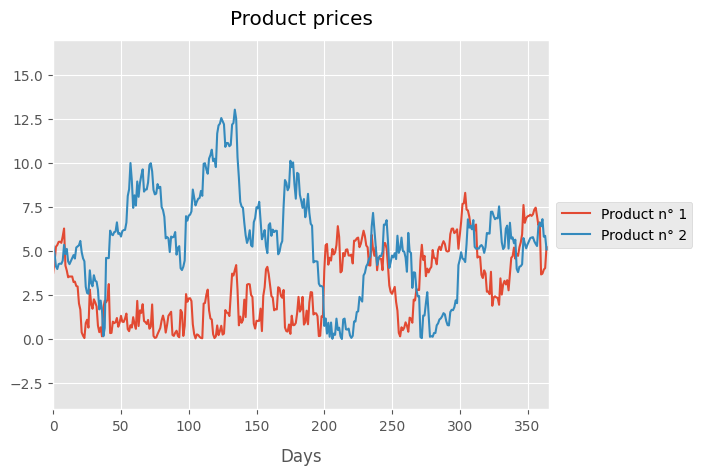

In [3]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

labels = ["Product n° " + str(i + 1) for i in range(0, n_p)]

plt.plot(T)
plt.title("Product prices", y=1.02)
plt.xlabel("Days", labelpad=10)
plt.legend(labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
ax = plt.gca()
ax.set_xlim([0, n_d + 1])
ax.set_ylim([-T.mean().round(), T.max().round() + T.mean().round()]);

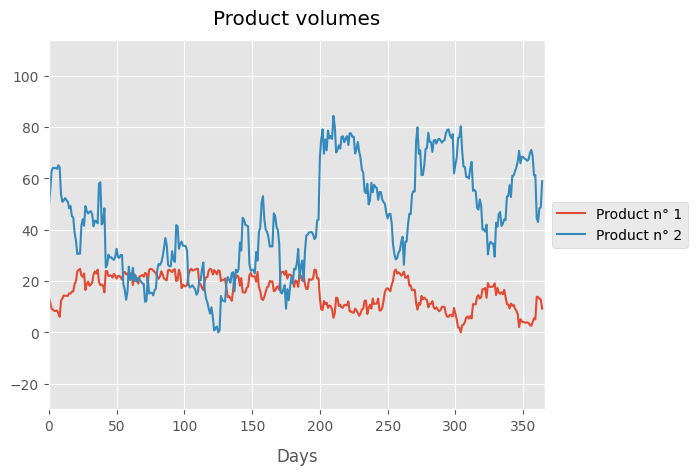

In [4]:
plt.plot(Y)
plt.title("Product volumes", y=1.02)
plt.xlabel("Days", labelpad=10)
plt.legend(labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
ax = plt.gca()
ax.set_xlim([0, n_d + 1])
ax.set_ylim([-Y.mean().round(), Y.max().round() + Y.mean().round()]);

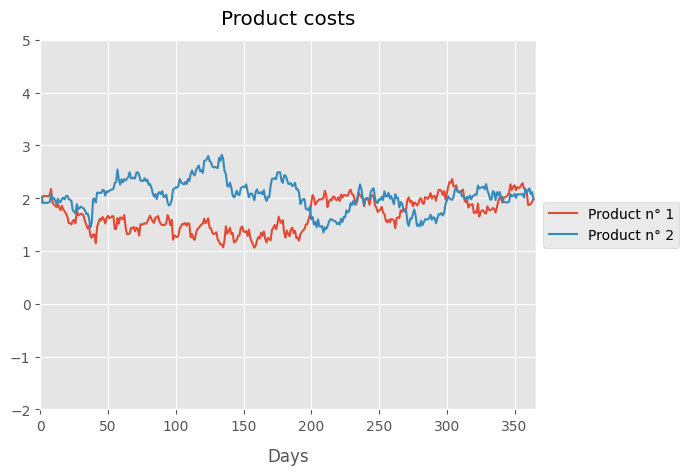

In [5]:
plt.plot(C)
plt.title("Product costs", y=1.02)
plt.xlabel("Days", labelpad=10)
plt.legend(labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
ax = plt.gca()
ax.set_xlim([0, n_d + 1])
ax.set_ylim([-C.mean().round(), C.max().round() + C.mean().round()]);

## 2. Estimation of cross-price elasticity with Double Machine Learning (DML)

### 2.1 Introduction

Price elasticity represents the relationship between price and demand sales volume for a given product. 

Under the assumption of a linear relationship, elasticity $K$ is defined as:

$$∆V=K⋅∆P$$
 
 
In the previous formula:
- $∆V$: change in volume (demand, units sold) caused by the change in price.
- $∆P$: change in price.
- $K$: proportionality coefficient known as price elasticity.
More information on the topic can be found in [Anderson et al. (1997)](https://scholar.harvard.edu/files/alada/files/price_elasticity_of_demand_handout.pdf).

We estimate price elasticity through __Double Machine Learning (DML)__ as in [Chernozhukov (2016)](https://arxiv.org/abs/1608.00060).

In brief, Double Machine Learning is a method for estimating __heterogeneous treatment effects__ over a target variable called outcome, when all the confounders are observed. 

__Confounders__ are features that affect both treatment and outcome. 

In dynamic pricing, the treatment is the conscious manipulation of product’s price towards profit or revenue maximization, while the outcome is the demand or volume for that product. 

Confounders may be, for instance, the application of discounts, coupons, seasonality, and any information that may affect both the price and the demand for a product. 

The structural assumptions of the model are as follows:

$$Y= θ(X)⋅T+g(X,W)+ϵ$$
$$T= f(X,W)+η$$
$$Ε[ϵ|X,W]=0$$
$$Ε[η|X,W]=0$$
$$Ε[η⋅ϵ|X,W]=0$$

where:
- $Y$: outcomes. In our case, the demand/volume.
- $T$: treatment. In our case, the prices.
- $X$: features that only affect the outcome, namely variables.
- $W$: features that affect both outcome and treatment, namely confounders.
- $θ(X)$: marginal conditional average treatment effect (CATE). In our case, the price elasticity K.
- $ϵ$ and $η$ represent error terms.
- $Ε[⋅|⋅]$: conditional expectation function.

### 2.2 DML experiment

In [6]:
from sklearn.linear_model import MultiTaskElasticNetCV
from econml.dml import LinearDML

# Double ML estimator
est = LinearDML(
    model_y=MultiTaskElasticNetCV(cv=3, tol=1, selection="random"),
    model_t=MultiTaskElasticNetCV(cv=3),
)

# Model fit
est.fit(Y=Y, T=T, X=None, W=W)

# Model summary
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|Y0|T0,-3.0,0.0,-10352.722,0.0,-3.001,-3.0
cate_intercept|Y0|T1,0.0,0.0,1.106,0.269,-0.0,0.001
cate_intercept|Y1|T0,6.002,0.004,1503.31,0.0,5.994,6.01
cate_intercept|Y1|T1,-4.003,0.003,-1364.61,0.0,-4.009,-3.997


### 2.3 CATE interpretation

The above estimate suggests that __increasing the price of product n° 1 by +10%__ ($T_0$) results in: 
- __sales drop of 30% for product n°1__ ($Y_0$), and
- __sales increase of 60% for product n°2__ ($Y_1$). 

The cross-price elasticity is not the final result of our solution, but rather a necessary intermediate step.  Nevertheless, it could still be leveraged independently from this solution as a powerful information to:

- Determine __whether and how products compete with one another__, then assess this competition using quantifiable and understandable metrics.
- Considering the product's competitors, make an educated guess as to the potential __impact of discounts or marketing initiatives__.

In [7]:
K = np.array([[-3.0, 0.0], [6.002, -4.003]])

<div class="alert alert-block alert-info">
<b>Note:</b>
    In our procedure, we estimate the price-elasticity.<br>
    By doing this, we assume that we are in <b>elastic</b> conditions, meaning that a price variation corresponds to a proportional change in the demand. <br>
    This is true for most businesses, from retail to large distribution.<br>
    Nevertheless, not all businesses work under this assumption. They are referred to as <b>inelastic</b>. In those cases, this strategy is not applicable.    
</div>

## 3. Forecast expected quantities

While DML gives us an estimate of the causal effect θ(X) of price manipulation over demand, __our final goal is the prediction of the set of prices that will maximize the business objectives__. 

In Causal Machine Learning, these prices are referred to as __counterfactual__, as they are directly produced by the intervention.

As we cannot predict directly the counterfactual prices and demand, we can write them as a combination of observational quantities and a contribution due to the intervention:

$$V_c=V_o+δV$$

where:
- $V_c$: counterfactual volume. The subscripts $c$ stands for $counterfactual$ quantities.
- $V_o$: observational volume. The subscripts $o$ stands for $observational$ quantities.
- $δV$: additional effect due to the treatment.

Therefore, the next step in our strategy is __forecasting the observational quantities__. 

Unlike counterfactual ones, __observational quantities are based entirely on previous values__. They refer to a condition in which the treatment is not applied, therefore no price manipulation is assumed. 

As a result, we can use __forecasting techniques__ to predict the observational quantities. 

In a real dynamic pricing application, we should forecast demands and prices for multiple products. For this reason, we could leverage the advantages provided by __DeepAR__ by [Salinas et al. (2019)](https://arxiv.org/pdf/1704.04110.pdf) from Amazon Research.

Indeed, in situations with many similar time series across a cross-sectional unit, such as the demand for a set of products over the past 12 months, one can benefit from training a single model jointly over all of the time series. __DeepAR__ uses this approach, and, in such scenarios, it __outperforms the standard ARIMA and ETS methods__.

Conveniently, DeepAr is __already available__ as Amazon SageMaker [estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html). The detailed implementation for the forecast of observational quantities is not the main scope of this notebook. For this reason, we will limit ourselves in considering the last price and volume values in our time series as example. Still, DeepAR would provide significant advantages where the demand and prices of multiple products should be predicted. One may find a __detailed, end-to-end tutorial on using DeepAR in a SageMaker Studio Notebook__ [here](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.html).

In [8]:
c = C[-1, :]
V_obs = Y[-1, :]
P_obs = T[-1, :]

## 4. Optimization 

We previously defined the counterfactual quantities as a combination of observational ones and an intervention effect:

$$V_c=V_o+δV$$

By using the definition of price elasticity, we can rewrite this expression for the i-th product as:

$$ {{V_c}^i} = {{V_o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ⋅ δP^j$$

$$ {{V_c}^i} = {{V_o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ⋅ ({{P_c}^j} - {{P_o}^j} )$$

In particular:
- $V_c^i$: counterfactual volume/demand of the i-th product.
- $V_o^i$: observational volume/demand of the i-th product (known from forecasting).
- $K_{ij}$: effect of the variation of price of the i-th product over the demand of the j-th product (cross-price elasticity known from DML).
- $P_c^j$: counterfactual price of the j-th product (known from forecasting).
- $P_o^j$: observational price of the j-th product (known from forecasting).

The previous analytical expression can be plugged in any objective function such as profit and optimized with respect to the counterfactual prices. 

Furthermore, we can impose constraints to the optimization problem modifying the feasible region in which the counterfactual prices are evaluated. Custom policies, regulations, and business rules can all be used as optimization constraints. Our framework provides the flexibility to accommodate any type and number of constraints.

The following sections provide the complete derivation for popular objective functions: __profit__ and __revenue__.

### 4.1 Objective functions

#### 4.1.1 Revenue

Define revenue $R$ as:

$$R = V_c ⋅ P_c$$

Formulate the problem of finding the set of prices that maximize the revenue as an optimization task:

$$ {max}_{P_c} \sum \limits _{i=1} ^{N} {{P_c}^i} ⋅ [ {V_{o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ( {P_{c}^j} - {P_{o}^j} ) ]$$

In matrix form, posed as minimization problem:

$$  {min}_{P_C} - [ P_{c}^T ⋅ ( V_{o} + K ⋅ ( P_{c} - P_{o} ) ) ]$$

In conclusion, the problem can be framed as follow:

- Objective function $f(P_{c})$: 

$$ -( P_{c}^T ⋅ (V_{o} + K ⋅ (P_{c} - P_{o}) ))$$

- Gradient $\nabla f(P_{C})$:

$$ - (K ⋅ ( P_{C} - P_{o}) + V_{o} + K^T ⋅ P_{c} $$

- Hessian $\nabla^2 f(P_{c})$:

$$- (K + K^T)$$

In [9]:
def revenue(x):
    return -np.dot(x, (V_obs + np.dot(K, (x - P_obs))))


def revenue_gradient(x):
    return -(np.dot(K, (x - P_obs)) + V_obs + np.dot(K.transpose(), x))


def revenue_hessian(x):
    return -(K + K.transpose())

#### 4.1.2 Profit

Define profit $Pr$ as:

$$ Pr = V_{c} ⋅ ( P_{c} - C)$$

Assumption: cost is independent from any potential modification of price:

$$ C_{c} = C_{o} = C $$

Formulate the problem of finding the set of prices that maximize the profit as an optimization task:

$$ {max}_{P_c} \sum \limits _{i=1} ^{N} {(P_{c}^i} - C^i) ⋅ [ {V_{o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ( {P_{c}^j} - {P_{o}^j} ) ]$$

In matrix form, posed as minimization problem:

$$ {min}_{P_c} - [ (P_{c} - C)^T ⋅ ( V_{o} + K ⋅ ( P_{c} - P_{o} ) ) ]$$

In conclusion, the problem can be framed as follow:

- Objective function $f(P_{c})$: 

$$ -( (P_{c} - C)^T ⋅ (V_{o} + K ⋅ (P_{c} - P_{o}) ))$$

- Gradient $\nabla f(P_{C})$:

$$ - (K ⋅ ( P_{c} - P_{o}) + V_{o} + K^T ⋅ (P_{c} - C)$$

- Hessian $\nabla^2 f(P_{c})$:

$$- (K + K^T)$$

In [10]:
def profit(x):
    return -(np.dot((x - c), (V_obs + np.dot(K, (x - P_obs)))))


def profit_gradient(x):
    return -(np.dot(K, (x - P_obs)) + V_obs + np.dot(K.transpose(), (x - c)))


def profit_hessian(x):
    return -(K + K.transpose())

### 4.2 Optimization constraints

#### 4.2.1 Linear constraints

We need to ensure that the feasible region will only account for positive counterfactual volumes. This can be achieved with a linear constraint, imposing: 

$$V_c≥0$$

Through price elasticity, we can formulate this condition as:

$$V_o+δV≥0$$

$$V_o+K ⋅(P_c-P_o )≥0$$

$$ K⋅P_c≥-V_o+K⋅P_o $$

Therefore, we can write the following linear constraint:

$$\text{ Lower bound } ≤ A⋅X ≤  \text{ Upper bound }$$

where:
- $A=K$
- $X= P_c$
- $\text{ Lower bound } = -V_o + K⋅P_o$
- $\text{ Upper bound } = Inf$

In [11]:
from scipy.optimize import LinearConstraint

A = K
lower_bound = -V_obs + np.dot(K, P_obs)
upper_bound = np.inf
lin_cons = LinearConstraint(A, lb=lower_bound, ub=upper_bound)

#### 4.2.2 Bounds

Bounds allow to estimate the objective function only between a specified range for the input variables.

In our case, we want the feasible region to be described by minimum and maximum prices. 

The application of such a perimeter allows to avoid sudden and highly different prices in short spans of time, in case the optimum price is too different from the one currently applied.

In [12]:
from scipy.optimize import Bounds

# Min historical prices for each product
min_prices = T.min(axis=0).tolist()

# Max historical prices for each product
max_prices = T.max(axis=0).tolist()

# Bounds on counterfactual prices
bounds = Bounds(min_prices, max_prices)

### 4.3 Solution

In [13]:
from scipy.optimize import minimize

result = minimize(
    revenue, P_obs, method="SLSQP", jac=revenue_gradient, bounds=bounds, constraints=lin_cons
)

result

     fun: -597.5729918342606
     jac: array([-4.84209270e+01,  2.13162821e-14])
 message: 'Optimization terminated successfully'
    nfev: 4
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 8.30398067, 12.21807215])

We found the set of counterfactual prices that maximize revenue.

We can observe the feasible region and the found minimizer:

<div class="alert alert-block alert-info">
<b>Dimensionality</b><br><br>
The following code snippet plots the objective function with respect to the counterfactual prices of two products.
<br>
When reproducing this notebook, please consider that a 3-D plot of the objective function is only possible when considering two products, one for each axis.<br>
<b>If more than two products have been generated in the previous passages, the following plot is not possible</b>.
</div>

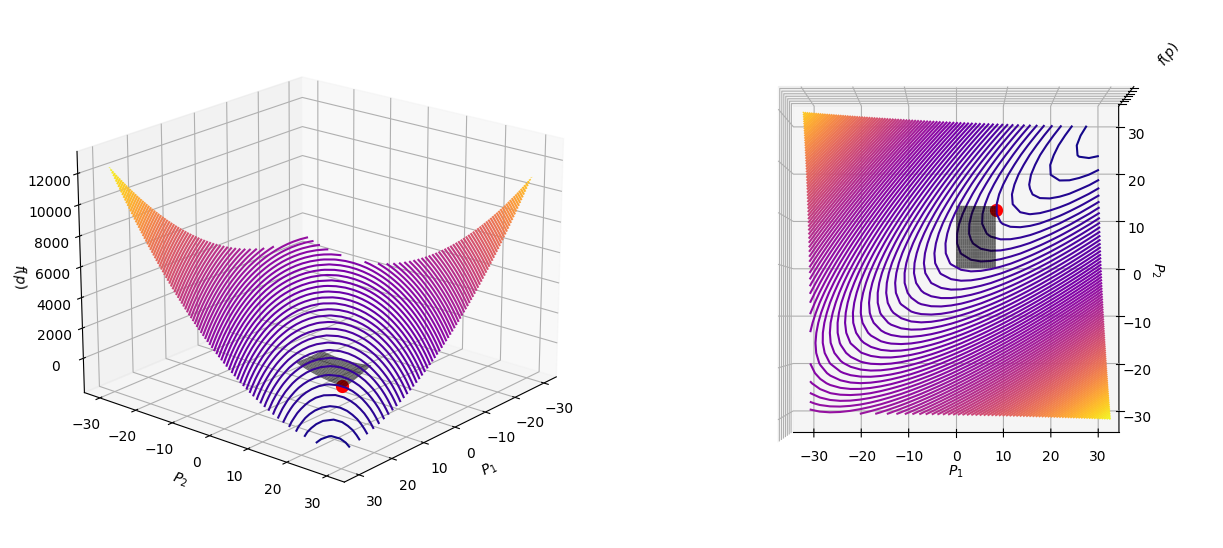

In [14]:
plt.style.use("default")


def revenue_by_xy(x, y):
    return -(
        V_obs[0] * x
        + V_obs[1] * y
        + x * (K[0][0] * (x - P_obs[0]) + K[0][1] * (y - P_obs[1]))
        + y * ((K[1][0] * (x - P_obs[0]) + K[1][1] * (y - P_obs[1])))
    )


def plot_revenue(min_value=0, max_value=10000):
    # Objective function
    x = np.linspace(min_value, max_value, 30)
    y = np.linspace(min_value, max_value, 30)
    X, Y = np.meshgrid(x, y)
    Z = revenue_by_xy(X, Y)

    # Minimum from the optimization task
    min_x0, min_x1 = np.meshgrid(result.x[0], result.x[1])
    min_z = revenue_by_xy(min_x0, min_x1)

    # Bounds area
    X0_bound, X1_bound = np.meshgrid(
        np.linspace(min_prices[0], max_prices[0], 20), np.linspace(min_prices[1], max_prices[1], 20)
    )
    Z_bound = revenue_by_xy(X0_bound, X1_bound)

    # Plot
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(1, 2, 1, projection="3d")
    ax.contour3D(X, Y, Z, 100, cmap="plasma")
    ax.scatter(min_x0, min_x1, min_z, marker="o", color="red", linewidth=5)
    ax.plot_surface(X0_bound, X1_bound, Z_bound, color="black", alpha=0.6)

    ax.set_xlabel("$P_1$")
    ax.set_ylabel("$P_2$")
    ax.view_init(20, 40)
    ax.set_zlabel("$f(p)$")

    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.contour3D(X, Y, Z, 100, cmap="plasma")
    ax.scatter(min_x0, min_x1, min_z, marker="o", color="red", linewidth=5)
    ax.plot_surface(X0_bound, X1_bound, Z_bound, color="black", alpha=0.6)
    ax.set_xlabel("$P_1$")
    ax.set_ylabel("$P_2$")
    ax.view_init(89, -90)
    ax.axes.zaxis.set_ticklabels([])
    ax.set_zlabel("$f(p)$")


plot_revenue(-30, 30)

Let us estimate counterfactual volumes and compare counterfactual and observational revenue:

In [15]:
# Counterfactual volumes
V_count = np.abs(
    np.floor(
        np.array(
            [
                V_obs[i]
                + (np.array([K[i][j] * (result.x[j] - P_obs[j]) for j in range(0, n_p)]).sum())
                for i in range(0, n_p)
            ]
        )
    )
)

# Counterfactual revenue
revenue_count = np.array([V_count[i] * result.x[i] for i in range(0, n_p)]).sum()

# Observational (expected) revenue
revenue_obs = np.array([V_obs[i] * P_obs[i] for i in range(0, n_p)]).sum()

In [16]:
import pandas as pd

pd.DataFrame(
    [P_obs.round(2), result.x.round(2), np.floor(V_obs), V_count],
    columns=labels,
    index=["Expected Prices", "Optimized Prices", "Expected Volumes", "Optimized Volumes"],
).T

,Expected Prices,Optimized Prices,Expected Volumes,Optimized Volumes
Product n° 1,5.21,8.30,9.0,0.0
Product n° 2,5.09,12.22,58.0,48.0


In [17]:
print("Expected revenue:\t{:.2f}".format(revenue_obs))
print("Counterfactual revenue:\t{:.2f}".format(revenue_count))
print("Revenue increase:\t{:.2f}".format((revenue_count - revenue_obs) * 100 / revenue_obs) + "%")

Expected revenue:	348.11
Counterfactual revenue:	586.47
Revenue increase:	68.47%


## 5. Simulation

Optimization provides a set of prices that maximizes a certain business goal (profit, revenue, ..).
Instead, __simulation works backwards__.

Simulation allows to __apply any custom price__, and verify what would happen to the business goal.
In this way, business users are free to __experiment different scenarios__ and further __adapt the solution__.

In conclusion, the simulation utility provides flexibility to business users answering the question: _What would happen to revenue or profit if I applied these prices?_

#### 5.1 Procedure

Decide, for each product, the price to be applied during the simulation: 

$$ \sum \limits _{i=1} ^{N} {set: P_c^i } $$

Estimate the volumes resulting from this application:

$$ {{V_c}^i} = {{V_o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ⋅ ({{P_c}^j} - {{P_o}^j} )$$

Calculate resulting counterfactual profit $Pr$:

$$ Pr_c = V_{c} ⋅ ( P_{c} - C)$$

$$ Pr_c = \sum \limits _{i=1} ^{N} {(P_{c}^i} - C^i) ⋅ [ {V_{o}^i} + \sum \limits _{j=1} ^{N} K_{ij} ( {P_{c}^j} - {P_{o}^j} ) ]$$

Compare it with the expected (observational profit) and verify a gain or loss:

$$ Pr_o = \sum \limits _{i=1} ^{N} {(P_{o}^i} - C^i) ⋅ {V_{o}^i}$$

In [18]:
# Simulated prices: custom prices applied by business users
sim_P = np.array([5, 5])

# Simulated volumes: expected from the simulated prices through elasticity
sim_V = np.floor(
    np.abs(
        np.array(
            [
                V_obs[i]
                + (np.array([K[i][j] * (sim_P[j] - P_obs[j]) for j in range(0, n_p)]).sum())
                for i in range(0, n_p)
            ]
        )
    )
)

# Simulated revenue
sim_revenue = np.array([sim_V[i] * sim_P[i] for i in range(0, n_p)]).sum()

print("Expected revenue:\t{:.2f}".format(revenue_obs))
print("Simulated revenue:\t{:.2f}".format(sim_revenue))
print("Revenue increase:\t{:.2f}".format((sim_revenue - revenue_obs) * 100 / revenue_obs) + "%")

Expected revenue:	348.11
Simulated revenue:	330.00
Revenue increase:	-5.20%
